In [1]:
import scipy.optimize as fitter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("light_mode")

# Resolution Testing for Convolution Coefficient Calculation

## Load in Data

In [2]:
timing_df_3PCF = pd.read_csv("paper_data/3PCF_timing_data.csv")
timing_df_4PCF = pd.read_csv("paper_data/4PCF_timing_data.csv")
timing_df_3PCF_projected = pd.read_csv("paper_data/3PCF_projected_timing_data.csv")
timing_df_4PCF_projected = pd.read_csv("paper_data/4PCF_projected_timing_data.csv")


dts_3PCF, dts_4PCF, dts_3PCF_p, dts_4PCF_p = [], [], [], []

row_3PCF = timing_df_3PCF.loc(0)
row_4PCF = timing_df_4PCF.loc(0)
row_3PCF_p = timing_df_3PCF_projected.loc(0)
row_4PCF_p = timing_df_4PCF_projected.loc(0)

for i in range(len(timing_df_3PCF_projected['resolution'])):
    dts_3PCF_p.append(np.sum(row_3PCF_p[i][2:6]))
    dts_4PCF_p.append(np.sum(row_4PCF_p[i][2:6]))
    dts_3PCF.append(np.sum(row_3PCF[i][2:8]))
    dts_4PCF.append(np.sum(row_4PCF[i][2:8]))




## Fit Data to Scaling Model

We note, that the fitted model parameters are only to show that the data does fit an $O(N_{\mathrm{g}} \log N_{\mathrm{g}})$ complexity scaling. 

In [3]:
#we have to define our model with our needed parameters
def model_NlogN(x, a, b, c):
    return a * x*np.log(b*x) + c


def compute_best_fit(dts, NPCF, projected_flag):

    if NPCF == 3:
        if projected_flag:
            Ns = np.array(list(timing_df_3PCF_projected["resolution"] ** 2))
        else:
            Ns = np.array(list(timing_df_3PCF["resolution"] ** 3))
    elif NPCF == 4:
        if projected_flag:
            Ns = np.array(list(timing_df_4PCF_projected["resolution"] ** 2))
        else:
            Ns = np.array(list(timing_df_4PCF["resolution"] ** 3))

    par0    = np.array([1.0, 2.0, 1.0]) # initial guess for parameters
    par, cov = fitter.curve_fit(model_NlogN, Ns, dts, par0 ,maxfev=10000) #fitter.curve_fit takes in the model, x,y data, guess, and sigma
    
    ##################################################################

    # par arrays contains the values of parameters. cov is the covariance matrix
    # decode it now
    a = par[0]
    ea = np.sqrt(cov[0,0])
    # print('a={0:6.8f}+/-{1:5.3f}'.format(a,ea))
    b = par[1]
    eb = np.sqrt(cov[1,1])
    # print('b={0:6.3f}+/-{1:5.3f}'.format(b,eb))
    c = par[2]
    ec = np.sqrt(cov[2,2])
    # print('c={0:6.3f}+/-{1:5.3f}'.format(c,ec))

    return [a,b,c], Ns

params_3pcf, Ns = compute_best_fit(dts_3PCF, 3, False)
params_4pcf, Ns = compute_best_fit(dts_4PCF, 4, False)
params_3pcf_proj, Ns_p = compute_best_fit(dts_3PCF_p, 3, True)
params_4pcf_proj, Ns_p = compute_best_fit(dts_4PCF_p, 4, True)

/Users/jamessunseri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
a1, b1,c1 = params_3pcf
a2,b2,c2 = params_4pcf
a3,b3,c3 = params_3pcf_proj
a4,b4,c4 = params_4pcf_proj

## Plot Data and Models

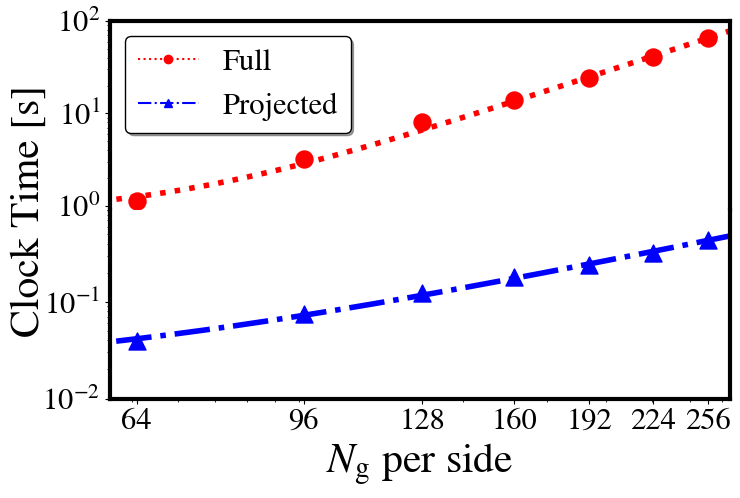

In [5]:

x_lin = np.linspace(30**3,270**3,1000)
x_lin_p = np.linspace(30**2,270**2,1000)
y_NlogN_3pcf = model_NlogN(x_lin, a1, b1,c1)
y_NlogN_4pcf = model_NlogN(x_lin, a2,b2,c2)
y_NlogN_3pcf_p = model_NlogN(x_lin_p, a3,b3,c3)
y_NlogN_4pcf_p = model_NlogN(x_lin_p, a4,b4,c4)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,5))

# fig.suptitle("Resolution Scaling: Harmonic Coefficient Calculation", fontsize=20)

#top plot
# ax1.plot(Ns, dts_3PCF, 'bo')
ax1.scatter(Ns, dts_4PCF, color='red', marker='o', s=150)
# ax1.plot(x_lin,y_NlogN_3pcf, color='red', linestyle='--')
ax1.plot(x_lin,y_NlogN_4pcf,color='red', linestyle=':', linewidth=4)
ax1.loglog()
ax1.set_xticks(Ns)


ax1.plot([],[], color='red', marker="o", linestyle=':', label='Full')
# ax1.plot([],[],color='red',marker="o",  linestyle=':', label='4PCF')
ax1.plot([],[], color='blue', marker="^", linestyle='-.', label='Projected')
# ax1.plot([],[],color='blue',marker="o",  linestyle='-')
ax1.set_xticklabels([])
ax1.set_xlim(60**3, 270**3)
ax1.set_ylim(0.90, 100)
ax1.legend(shadow=True, edgecolor="black")


# ax2.scatter(Ns_p, dts_3PCF_p, color='blue', marker='o')
ax2.scatter(Ns_p, dts_4PCF_p, color='blue', marker='^', s=150)
# ax2.plot(x_lin_p,y_NlogN_3pcf_p, color='blue', linestyle='-.', label='3PCF Proj.')
ax2.plot(x_lin_p,y_NlogN_4pcf_p,color='blue', linestyle='-.',linewidth=4, label='4PCF Proj.')
ax2.loglog()
ax2.set_ylim(0.01, 0.9)
ax2.set_xticks(Ns_p)
ax2.set_xticklabels([int(np.round(Ns_p[i]**(1/2))) for i in range(len(Ns_p))])
ax2.set_xlabel("$N_{\\mathrm{g}}$ per side", fontsize=30)
# ax2.set_ylabel("Clock Time [s]")
fig.text(0, 0.5, 'Clock Time [s]', va='center', rotation='vertical', fontsize=30)
# ax2.legend()

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax1.xt['top'].set_visible(False)
# ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
# ax2.set_xticks([])
ax2.set_xlim(60**2, 270**2)

plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
# plt.savefig("Final_Resolution_Scaling_NLOGN.pdf")
plt.show()